In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import *
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import time
import copy
import os

In [2]:
batch_size = 8
learning_rate = 0.001

transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = datasets.ImageFolder(root='emotion5/train/', transform=transforms)
test_dataset = datasets.ImageFolder(root='emotion5/test/', transform=transforms)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
def imshow(inp, title=None):
    
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

images-size: torch.Size([8, 3, 224, 224])
out-size: torch.Size([3, 228, 1810])


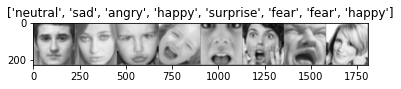

In [4]:
images, labels = next(iter(train_dataloader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

imshow(out, title=[train_dataset.classes[x] for x in labels])

In [5]:
net = torch.hub.load('pytorch/vision:v0.9.0', 'wide_resnet101_2', pretrained=True)
net = net.cuda() if device else net
net

Using cache found in C:\Users\Otakuking/.cache\torch\hub\pytorch_vision_v0.9.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), strid

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, 
                 betas=(0.9, 0.999), 
                 eps=1e-08, 
                 weight_decay=0, 
                 amsgrad=True)

def accuracy(out, labels):
    _,pred = torch.max(out, dim=1)
    return torch.sum(pred==labels).item()

num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 48)
net.fc = net.fc.cuda() if device else net.fc

In [ ]:
n_epochs = 30
print_every = 10
valid_loss_min = np.Inf
val_loss = []
val_acc = []
train_loss = []
train_acc = []
total_step = len(train_dataloader)
for epoch in range(1, n_epochs+1):
    running_loss = 0.0
    correct = 0
    total=0
    print(f'Epoch {epoch}\n')
    for batch_idx, (data_, target_) in enumerate(train_dataloader):
        data_, target_ = data_.to(device), target_.to(device)
        optimizer.zero_grad()
        
        outputs = net(data_)
        loss = criterion(outputs, target_)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _,pred = torch.max(outputs, dim=1)
        correct += torch.sum(pred==target_).item()
        total += target_.size(0)
        if (batch_idx) % 20 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch, n_epochs, batch_idx, total_step, loss.item()))
    train_acc.append(100 * correct / total)
    train_loss.append(running_loss/total_step)
    print(f'\ntrain-loss: {np.mean(train_loss):.4f}, train-acc: {(100 * correct/total):.4f}')
    batch_loss = 0
    total_t=0
    correct_t=0
    with torch.no_grad():
        net.eval()
        for data_t, target_t in (test_dataloader):
            data_t, target_t = data_t.to(device), target_t.to(device)
            outputs_t = net(data_t)
            loss_t = criterion(outputs_t, target_t)
            batch_loss += loss_t.item()
            _,pred_t = torch.max(outputs_t, dim=1)
            correct_t += torch.sum(pred_t==target_t).item()
            total_t += target_t.size(0)
        val_acc.append(100 * correct_t/total_t)
        val_loss.append(batch_loss/len(test_dataloader))
        network_learned = batch_loss < valid_loss_min
        print(f'validation loss: {np.mean(val_loss):.4f}, validation acc: {(100 * correct_t/total_t):.4f}\n')

        
        if network_learned:
            valid_loss_min = batch_loss
            torch.save(net.state_dict(), 'WideResnet101_adam_batch8_learninglr0.001_nnlinear48_epoch30.pt')
            print('Improvement-Detected, save-model')
    net.train()

Epoch 1

Epoch [1/30], Step [0/3535], Loss: 3.8566
Epoch [1/30], Step [20/3535], Loss: 3.2311
Epoch [1/30], Step [40/3535], Loss: 3.4107
Epoch [1/30], Step [60/3535], Loss: 2.9420
Epoch [1/30], Step [80/3535], Loss: 2.7493
Epoch [1/30], Step [100/3535], Loss: 2.7560
Epoch [1/30], Step [120/3535], Loss: 2.1847
Epoch [1/30], Step [140/3535], Loss: 2.4083
Epoch [1/30], Step [160/3535], Loss: 2.4361
Epoch [1/30], Step [180/3535], Loss: 2.2394
Epoch [1/30], Step [200/3535], Loss: 2.5733
Epoch [1/30], Step [220/3535], Loss: 2.4062
Epoch [1/30], Step [240/3535], Loss: 2.2114
Epoch [1/30], Step [260/3535], Loss: 2.5688
Epoch [1/30], Step [280/3535], Loss: 2.1994
Epoch [1/30], Step [300/3535], Loss: 2.0434
Epoch [1/30], Step [320/3535], Loss: 2.2990
Epoch [1/30], Step [340/3535], Loss: 2.0599
Epoch [1/30], Step [360/3535], Loss: 1.9394
Epoch [1/30], Step [380/3535], Loss: 1.9100
Epoch [1/30], Step [400/3535], Loss: 2.1608
Epoch [1/30], Step [420/3535], Loss: 2.0439
Epoch [1/30], Step [440/3535]

Epoch [2/30], Step [80/3535], Loss: 1.4734
Epoch [2/30], Step [100/3535], Loss: 1.7926
Epoch [2/30], Step [120/3535], Loss: 1.3935
Epoch [2/30], Step [140/3535], Loss: 1.6058
Epoch [2/30], Step [160/3535], Loss: 2.0115
Epoch [2/30], Step [180/3535], Loss: 1.6030
Epoch [2/30], Step [200/3535], Loss: 1.3199
Epoch [2/30], Step [220/3535], Loss: 2.0166
Epoch [2/30], Step [240/3535], Loss: 1.3355
Epoch [2/30], Step [260/3535], Loss: 1.7097
Epoch [2/30], Step [280/3535], Loss: 1.6031
Epoch [2/30], Step [300/3535], Loss: 1.7300
Epoch [2/30], Step [320/3535], Loss: 1.6540
Epoch [2/30], Step [340/3535], Loss: 1.2006
Epoch [2/30], Step [360/3535], Loss: 1.7626
Epoch [2/30], Step [380/3535], Loss: 2.0476
Epoch [2/30], Step [400/3535], Loss: 1.7030
Epoch [2/30], Step [420/3535], Loss: 1.5740
Epoch [2/30], Step [440/3535], Loss: 1.6121
Epoch [2/30], Step [460/3535], Loss: 1.6286
Epoch [2/30], Step [480/3535], Loss: 1.7591
Epoch [2/30], Step [500/3535], Loss: 1.9895
Epoch [2/30], Step [520/3535], Lo

Epoch [3/30], Step [160/3535], Loss: 1.3929
Epoch [3/30], Step [180/3535], Loss: 1.3544
Epoch [3/30], Step [200/3535], Loss: 1.7213
Epoch [3/30], Step [220/3535], Loss: 1.0380
Epoch [3/30], Step [240/3535], Loss: 1.5780
Epoch [3/30], Step [260/3535], Loss: 1.4394
Epoch [3/30], Step [280/3535], Loss: 1.0300
Epoch [3/30], Step [300/3535], Loss: 1.1169
Epoch [3/30], Step [320/3535], Loss: 1.6245
Epoch [3/30], Step [340/3535], Loss: 1.0957
Epoch [3/30], Step [360/3535], Loss: 1.3968
Epoch [3/30], Step [380/3535], Loss: 1.9945
Epoch [3/30], Step [400/3535], Loss: 1.8662
Epoch [3/30], Step [420/3535], Loss: 1.6498
Epoch [3/30], Step [440/3535], Loss: 1.1110
Epoch [3/30], Step [460/3535], Loss: 1.4647
Epoch [3/30], Step [480/3535], Loss: 1.0523
Epoch [3/30], Step [500/3535], Loss: 1.1925
Epoch [3/30], Step [520/3535], Loss: 1.6198
Epoch [3/30], Step [540/3535], Loss: 1.1940
Epoch [3/30], Step [560/3535], Loss: 1.1655
Epoch [3/30], Step [580/3535], Loss: 1.3705
Epoch [3/30], Step [600/3535], L

Epoch [4/30], Step [240/3535], Loss: 1.4351
Epoch [4/30], Step [260/3535], Loss: 1.0547
Epoch [4/30], Step [280/3535], Loss: 1.0577
Epoch [4/30], Step [300/3535], Loss: 1.2299
Epoch [4/30], Step [320/3535], Loss: 0.8473
Epoch [4/30], Step [340/3535], Loss: 0.8995
Epoch [4/30], Step [360/3535], Loss: 1.7943
Epoch [4/30], Step [380/3535], Loss: 1.2832
Epoch [4/30], Step [400/3535], Loss: 1.4476
Epoch [4/30], Step [420/3535], Loss: 1.0985
Epoch [4/30], Step [440/3535], Loss: 1.1595
Epoch [4/30], Step [460/3535], Loss: 1.2165
Epoch [4/30], Step [480/3535], Loss: 1.2100
Epoch [4/30], Step [500/3535], Loss: 0.7375
Epoch [4/30], Step [520/3535], Loss: 1.3640
Epoch [4/30], Step [540/3535], Loss: 1.4294
Epoch [4/30], Step [560/3535], Loss: 1.3315
Epoch [4/30], Step [580/3535], Loss: 1.4867
Epoch [4/30], Step [600/3535], Loss: 1.2851
Epoch [4/30], Step [620/3535], Loss: 1.1041
Epoch [4/30], Step [640/3535], Loss: 0.8898
Epoch [4/30], Step [660/3535], Loss: 1.0616
Epoch [4/30], Step [680/3535], L

Epoch [5/30], Step [320/3535], Loss: 0.9674
Epoch [5/30], Step [340/3535], Loss: 1.3619
Epoch [5/30], Step [360/3535], Loss: 0.8894
Epoch [5/30], Step [380/3535], Loss: 1.0366
Epoch [5/30], Step [400/3535], Loss: 1.5616
Epoch [5/30], Step [420/3535], Loss: 0.7034
Epoch [5/30], Step [440/3535], Loss: 0.9175
Epoch [5/30], Step [460/3535], Loss: 1.6946
Epoch [5/30], Step [480/3535], Loss: 0.7981
Epoch [5/30], Step [500/3535], Loss: 0.7654
Epoch [5/30], Step [520/3535], Loss: 0.9405
Epoch [5/30], Step [540/3535], Loss: 1.1327
Epoch [5/30], Step [560/3535], Loss: 0.5479
Epoch [5/30], Step [580/3535], Loss: 0.9513
Epoch [5/30], Step [600/3535], Loss: 0.7529
Epoch [5/30], Step [620/3535], Loss: 0.9517
Epoch [5/30], Step [640/3535], Loss: 1.1200
Epoch [5/30], Step [660/3535], Loss: 1.4606
Epoch [5/30], Step [680/3535], Loss: 1.0050
Epoch [5/30], Step [700/3535], Loss: 1.6478
Epoch [5/30], Step [720/3535], Loss: 0.6620
Epoch [5/30], Step [740/3535], Loss: 0.8438
Epoch [5/30], Step [760/3535], L

Epoch [6/30], Step [400/3535], Loss: 0.5365
Epoch [6/30], Step [420/3535], Loss: 1.1833
Epoch [6/30], Step [440/3535], Loss: 1.3216
Epoch [6/30], Step [460/3535], Loss: 1.5488
Epoch [6/30], Step [480/3535], Loss: 1.0387
Epoch [6/30], Step [500/3535], Loss: 0.6876
Epoch [6/30], Step [520/3535], Loss: 1.0149
Epoch [6/30], Step [540/3535], Loss: 1.2174
Epoch [6/30], Step [560/3535], Loss: 0.8386
Epoch [6/30], Step [580/3535], Loss: 1.6195
Epoch [6/30], Step [600/3535], Loss: 1.3632
Epoch [6/30], Step [620/3535], Loss: 0.5621
Epoch [6/30], Step [640/3535], Loss: 1.3113
Epoch [6/30], Step [660/3535], Loss: 1.0567
Epoch [6/30], Step [680/3535], Loss: 1.5896
Epoch [6/30], Step [700/3535], Loss: 1.9497
Epoch [6/30], Step [720/3535], Loss: 1.5275
Epoch [6/30], Step [740/3535], Loss: 1.1490
Epoch [6/30], Step [760/3535], Loss: 1.0894
Epoch [6/30], Step [780/3535], Loss: 1.9200
Epoch [6/30], Step [800/3535], Loss: 1.1914
Epoch [6/30], Step [820/3535], Loss: 1.3247
Epoch [6/30], Step [840/3535], L

Epoch [7/30], Step [480/3535], Loss: 1.5126
Epoch [7/30], Step [500/3535], Loss: 1.3923
Epoch [7/30], Step [520/3535], Loss: 1.3995
Epoch [7/30], Step [540/3535], Loss: 1.4393
Epoch [7/30], Step [560/3535], Loss: 0.7096
Epoch [7/30], Step [580/3535], Loss: 1.2674
Epoch [7/30], Step [600/3535], Loss: 0.8093
Epoch [7/30], Step [620/3535], Loss: 0.8980
Epoch [7/30], Step [640/3535], Loss: 0.7915
Epoch [7/30], Step [660/3535], Loss: 1.8060
Epoch [7/30], Step [680/3535], Loss: 0.9040
Epoch [7/30], Step [700/3535], Loss: 0.7435
Epoch [7/30], Step [720/3535], Loss: 0.8580
Epoch [7/30], Step [740/3535], Loss: 0.9831
Epoch [7/30], Step [760/3535], Loss: 0.8872
Epoch [7/30], Step [780/3535], Loss: 1.1935
Epoch [7/30], Step [800/3535], Loss: 1.2831
Epoch [7/30], Step [820/3535], Loss: 1.1350
Epoch [7/30], Step [840/3535], Loss: 1.0044
Epoch [7/30], Step [860/3535], Loss: 0.5527
Epoch [7/30], Step [880/3535], Loss: 1.1622
Epoch [7/30], Step [900/3535], Loss: 1.4267
Epoch [7/30], Step [920/3535], L

Epoch [8/30], Step [560/3535], Loss: 0.6033
Epoch [8/30], Step [580/3535], Loss: 0.6337
Epoch [8/30], Step [600/3535], Loss: 1.2541
Epoch [8/30], Step [620/3535], Loss: 0.8705
Epoch [8/30], Step [640/3535], Loss: 0.6250
Epoch [8/30], Step [660/3535], Loss: 0.5052
Epoch [8/30], Step [680/3535], Loss: 0.8235
Epoch [8/30], Step [700/3535], Loss: 1.2491
Epoch [8/30], Step [720/3535], Loss: 1.0592
Epoch [8/30], Step [740/3535], Loss: 0.9243
Epoch [8/30], Step [760/3535], Loss: 0.5162
Epoch [8/30], Step [780/3535], Loss: 0.9700
Epoch [8/30], Step [800/3535], Loss: 1.2335
Epoch [8/30], Step [820/3535], Loss: 0.5713
Epoch [8/30], Step [840/3535], Loss: 0.8890
Epoch [8/30], Step [860/3535], Loss: 0.8812
Epoch [8/30], Step [880/3535], Loss: 1.2669
Epoch [8/30], Step [900/3535], Loss: 0.9058
Epoch [8/30], Step [920/3535], Loss: 0.7699
Epoch [8/30], Step [940/3535], Loss: 0.3293
Epoch [8/30], Step [960/3535], Loss: 0.7131
Epoch [8/30], Step [980/3535], Loss: 0.8415
Epoch [8/30], Step [1000/3535], 

Epoch [9/30], Step [660/3535], Loss: 0.6907
Epoch [9/30], Step [680/3535], Loss: 1.8335
Epoch [9/30], Step [700/3535], Loss: 0.6339
Epoch [9/30], Step [720/3535], Loss: 0.6596
Epoch [9/30], Step [740/3535], Loss: 0.4212
Epoch [9/30], Step [760/3535], Loss: 1.5490
Epoch [9/30], Step [780/3535], Loss: 1.1063
Epoch [9/30], Step [800/3535], Loss: 0.6248
Epoch [9/30], Step [820/3535], Loss: 0.9915
Epoch [9/30], Step [840/3535], Loss: 1.2360
Epoch [9/30], Step [860/3535], Loss: 0.5324
Epoch [9/30], Step [880/3535], Loss: 0.6795
Epoch [9/30], Step [900/3535], Loss: 1.0149
Epoch [9/30], Step [920/3535], Loss: 0.8158
Epoch [9/30], Step [940/3535], Loss: 1.4321
Epoch [9/30], Step [960/3535], Loss: 0.6135
Epoch [9/30], Step [980/3535], Loss: 0.6545
Epoch [9/30], Step [1000/3535], Loss: 1.0343
Epoch [9/30], Step [1020/3535], Loss: 1.0700
Epoch [9/30], Step [1040/3535], Loss: 1.6071
Epoch [9/30], Step [1060/3535], Loss: 1.1383
Epoch [9/30], Step [1080/3535], Loss: 0.3288
Epoch [9/30], Step [1100/35

Epoch [10/30], Step [740/3535], Loss: 0.5863
Epoch [10/30], Step [760/3535], Loss: 0.4444
Epoch [10/30], Step [780/3535], Loss: 0.4631
Epoch [10/30], Step [800/3535], Loss: 1.0813
Epoch [10/30], Step [820/3535], Loss: 1.0090
Epoch [10/30], Step [840/3535], Loss: 1.1064
Epoch [10/30], Step [860/3535], Loss: 1.1199
Epoch [10/30], Step [880/3535], Loss: 1.6745
Epoch [10/30], Step [900/3535], Loss: 0.6323
Epoch [10/30], Step [920/3535], Loss: 1.1213
Epoch [10/30], Step [940/3535], Loss: 2.7244
Epoch [10/30], Step [960/3535], Loss: 0.4699
Epoch [10/30], Step [980/3535], Loss: 1.1917
Epoch [10/30], Step [1000/3535], Loss: 0.8516
Epoch [10/30], Step [1020/3535], Loss: 1.3668
Epoch [10/30], Step [1040/3535], Loss: 0.5508
Epoch [10/30], Step [1060/3535], Loss: 1.3021
Epoch [10/30], Step [1080/3535], Loss: 1.1778
Epoch [10/30], Step [1100/3535], Loss: 1.1572
Epoch [10/30], Step [1120/3535], Loss: 0.8577
Epoch [10/30], Step [1140/3535], Loss: 1.2878
Epoch [10/30], Step [1160/3535], Loss: 0.8491
E

Epoch [11/30], Step [760/3535], Loss: 0.8074
Epoch [11/30], Step [780/3535], Loss: 0.6904
Epoch [11/30], Step [800/3535], Loss: 0.8113
Epoch [11/30], Step [820/3535], Loss: 0.5505
Epoch [11/30], Step [840/3535], Loss: 0.7446
Epoch [11/30], Step [860/3535], Loss: 1.2208
Epoch [11/30], Step [880/3535], Loss: 0.7898
Epoch [11/30], Step [900/3535], Loss: 0.4879
Epoch [11/30], Step [920/3535], Loss: 1.7714
Epoch [11/30], Step [940/3535], Loss: 1.1960
Epoch [11/30], Step [960/3535], Loss: 0.7757
Epoch [11/30], Step [980/3535], Loss: 1.3332
Epoch [11/30], Step [1000/3535], Loss: 0.5235
Epoch [11/30], Step [1020/3535], Loss: 0.6155
Epoch [11/30], Step [1040/3535], Loss: 0.5186
Epoch [11/30], Step [1060/3535], Loss: 0.5932
Epoch [11/30], Step [1080/3535], Loss: 0.8460
Epoch [11/30], Step [1100/3535], Loss: 0.8711
Epoch [11/30], Step [1120/3535], Loss: 1.0749
Epoch [11/30], Step [1140/3535], Loss: 0.9728
Epoch [11/30], Step [1160/3535], Loss: 0.5394
Epoch [11/30], Step [1180/3535], Loss: 0.9698


Epoch [12/30], Step [780/3535], Loss: 0.2467
Epoch [12/30], Step [800/3535], Loss: 0.8676
Epoch [12/30], Step [820/3535], Loss: 0.8305
Epoch [12/30], Step [840/3535], Loss: 0.8678
Epoch [12/30], Step [860/3535], Loss: 1.7282
Epoch [12/30], Step [880/3535], Loss: 0.3275
Epoch [12/30], Step [900/3535], Loss: 0.2777
Epoch [12/30], Step [920/3535], Loss: 1.0398
Epoch [12/30], Step [940/3535], Loss: 0.5001
Epoch [12/30], Step [960/3535], Loss: 1.2180
Epoch [12/30], Step [980/3535], Loss: 0.1872
Epoch [12/30], Step [1000/3535], Loss: 1.1211
Epoch [12/30], Step [1020/3535], Loss: 1.0346
Epoch [12/30], Step [1040/3535], Loss: 1.2499
Epoch [12/30], Step [1060/3535], Loss: 0.7726
Epoch [12/30], Step [1080/3535], Loss: 0.7347
Epoch [12/30], Step [1100/3535], Loss: 0.5349
Epoch [12/30], Step [1120/3535], Loss: 0.8655
Epoch [12/30], Step [1140/3535], Loss: 0.9849
Epoch [12/30], Step [1160/3535], Loss: 0.8650
Epoch [12/30], Step [1180/3535], Loss: 1.0429
Epoch [12/30], Step [1200/3535], Loss: 0.6126

Epoch [13/30], Step [780/3535], Loss: 0.3663
Epoch [13/30], Step [800/3535], Loss: 0.6017
Epoch [13/30], Step [820/3535], Loss: 0.8359
Epoch [13/30], Step [840/3535], Loss: 0.7616
Epoch [13/30], Step [860/3535], Loss: 0.7406
Epoch [13/30], Step [880/3535], Loss: 0.2761
Epoch [13/30], Step [900/3535], Loss: 0.4293
Epoch [13/30], Step [920/3535], Loss: 0.3970
Epoch [13/30], Step [940/3535], Loss: 0.3849
Epoch [13/30], Step [960/3535], Loss: 0.5242
Epoch [13/30], Step [980/3535], Loss: 0.6569
Epoch [13/30], Step [1000/3535], Loss: 0.4208
Epoch [13/30], Step [1020/3535], Loss: 0.9562
Epoch [13/30], Step [1040/3535], Loss: 0.7393
Epoch [13/30], Step [1060/3535], Loss: 0.3826
Epoch [13/30], Step [1080/3535], Loss: 1.0933
Epoch [13/30], Step [1100/3535], Loss: 0.5004
Epoch [13/30], Step [1120/3535], Loss: 0.6064
Epoch [13/30], Step [1140/3535], Loss: 0.9181
Epoch [13/30], Step [1160/3535], Loss: 0.4659
Epoch [13/30], Step [1180/3535], Loss: 0.6559
Epoch [13/30], Step [1200/3535], Loss: 0.9381

Epoch [14/30], Step [800/3535], Loss: 0.7745
Epoch [14/30], Step [820/3535], Loss: 1.0461
Epoch [14/30], Step [840/3535], Loss: 0.5645
Epoch [14/30], Step [860/3535], Loss: 0.2710
Epoch [14/30], Step [880/3535], Loss: 1.3190
Epoch [14/30], Step [900/3535], Loss: 0.6112
Epoch [14/30], Step [920/3535], Loss: 0.4479
Epoch [14/30], Step [940/3535], Loss: 0.3580
Epoch [14/30], Step [960/3535], Loss: 0.7266
Epoch [14/30], Step [980/3535], Loss: 1.0051
Epoch [14/30], Step [1000/3535], Loss: 0.2439
Epoch [14/30], Step [1020/3535], Loss: 0.4247
Epoch [14/30], Step [1040/3535], Loss: 0.3901
Epoch [14/30], Step [1060/3535], Loss: 0.5452
Epoch [14/30], Step [1080/3535], Loss: 0.5853
Epoch [14/30], Step [1100/3535], Loss: 0.6542
Epoch [14/30], Step [1120/3535], Loss: 0.8154
Epoch [14/30], Step [1140/3535], Loss: 0.1783
Epoch [14/30], Step [1160/3535], Loss: 0.8389
Epoch [14/30], Step [1180/3535], Loss: 0.5198
Epoch [14/30], Step [1200/3535], Loss: 1.0177
Epoch [14/30], Step [1220/3535], Loss: 0.752

Epoch [15/30], Step [820/3535], Loss: 0.3675
Epoch [15/30], Step [840/3535], Loss: 0.8067
Epoch [15/30], Step [860/3535], Loss: 0.3083
Epoch [15/30], Step [880/3535], Loss: 0.3753
Epoch [15/30], Step [900/3535], Loss: 0.4825
Epoch [15/30], Step [920/3535], Loss: 1.0095
Epoch [15/30], Step [940/3535], Loss: 0.3274
Epoch [15/30], Step [960/3535], Loss: 1.2396
Epoch [15/30], Step [980/3535], Loss: 0.2455
Epoch [15/30], Step [1000/3535], Loss: 0.1368
Epoch [15/30], Step [1020/3535], Loss: 0.5376
Epoch [15/30], Step [1040/3535], Loss: 0.2587
Epoch [15/30], Step [1060/3535], Loss: 1.0584
Epoch [15/30], Step [1080/3535], Loss: 0.4008
Epoch [15/30], Step [1100/3535], Loss: 0.5506
Epoch [15/30], Step [1120/3535], Loss: 0.7197
Epoch [15/30], Step [1140/3535], Loss: 0.3818
Epoch [15/30], Step [1160/3535], Loss: 0.2835
Epoch [15/30], Step [1180/3535], Loss: 0.3260
Epoch [15/30], Step [1200/3535], Loss: 0.9318
Epoch [15/30], Step [1220/3535], Loss: 0.1849
Epoch [15/30], Step [1240/3535], Loss: 0.39

Epoch [16/30], Step [840/3535], Loss: 1.1552
Epoch [16/30], Step [860/3535], Loss: 0.3006
Epoch [16/30], Step [880/3535], Loss: 0.9774
Epoch [16/30], Step [900/3535], Loss: 0.2664
Epoch [16/30], Step [920/3535], Loss: 0.2873
Epoch [16/30], Step [940/3535], Loss: 0.2363
Epoch [16/30], Step [960/3535], Loss: 1.0433
Epoch [16/30], Step [980/3535], Loss: 0.6533
Epoch [16/30], Step [1000/3535], Loss: 0.4061
Epoch [16/30], Step [1020/3535], Loss: 0.7374
Epoch [16/30], Step [1040/3535], Loss: 0.1880
Epoch [16/30], Step [1060/3535], Loss: 0.7562
Epoch [16/30], Step [1080/3535], Loss: 0.3968
Epoch [16/30], Step [1100/3535], Loss: 0.8293
Epoch [16/30], Step [1120/3535], Loss: 0.7096
Epoch [16/30], Step [1140/3535], Loss: 0.4123
Epoch [16/30], Step [1160/3535], Loss: 0.2980
Epoch [16/30], Step [1180/3535], Loss: 0.1636
Epoch [16/30], Step [1200/3535], Loss: 0.5198
Epoch [16/30], Step [1220/3535], Loss: 0.1815
Epoch [16/30], Step [1240/3535], Loss: 0.1040
Epoch [16/30], Step [1260/3535], Loss: 0.8

Epoch [17/30], Step [860/3535], Loss: 0.4975
Epoch [17/30], Step [880/3535], Loss: 0.1333
Epoch [17/30], Step [900/3535], Loss: 0.3448
Epoch [17/30], Step [920/3535], Loss: 0.2613
Epoch [17/30], Step [940/3535], Loss: 0.0490
Epoch [17/30], Step [960/3535], Loss: 0.0631
Epoch [17/30], Step [980/3535], Loss: 0.5044
Epoch [17/30], Step [1000/3535], Loss: 0.1614
Epoch [17/30], Step [1020/3535], Loss: 0.8457
Epoch [17/30], Step [1040/3535], Loss: 1.3367
Epoch [17/30], Step [1060/3535], Loss: 0.6915
Epoch [17/30], Step [1080/3535], Loss: 0.5952
Epoch [17/30], Step [1100/3535], Loss: 0.2917
Epoch [17/30], Step [1120/3535], Loss: 0.3689
Epoch [17/30], Step [1140/3535], Loss: 1.0069
Epoch [17/30], Step [1160/3535], Loss: 0.3096
Epoch [17/30], Step [1180/3535], Loss: 0.5447
Epoch [17/30], Step [1200/3535], Loss: 0.4347
Epoch [17/30], Step [1220/3535], Loss: 0.4113
Epoch [17/30], Step [1240/3535], Loss: 0.4685
Epoch [17/30], Step [1260/3535], Loss: 0.5973
Epoch [17/30], Step [1280/3535], Loss: 0.

Epoch [18/30], Step [880/3535], Loss: 0.2484
Epoch [18/30], Step [900/3535], Loss: 0.3591
Epoch [18/30], Step [920/3535], Loss: 0.4230
Epoch [18/30], Step [940/3535], Loss: 0.1000
Epoch [18/30], Step [960/3535], Loss: 0.3366
Epoch [18/30], Step [980/3535], Loss: 0.3035
Epoch [18/30], Step [1000/3535], Loss: 0.1208
Epoch [18/30], Step [1020/3535], Loss: 0.3797
Epoch [18/30], Step [1040/3535], Loss: 0.2526
Epoch [18/30], Step [1060/3535], Loss: 0.4112
Epoch [18/30], Step [1080/3535], Loss: 0.3085
Epoch [18/30], Step [1100/3535], Loss: 0.2615
Epoch [18/30], Step [1120/3535], Loss: 0.1416
Epoch [18/30], Step [1140/3535], Loss: 0.6393
Epoch [18/30], Step [1160/3535], Loss: 0.2741
Epoch [18/30], Step [1180/3535], Loss: 0.2036
Epoch [18/30], Step [1200/3535], Loss: 0.0440
Epoch [18/30], Step [1220/3535], Loss: 0.3425
Epoch [18/30], Step [1240/3535], Loss: 0.3754
Epoch [18/30], Step [1260/3535], Loss: 0.2228
Epoch [18/30], Step [1280/3535], Loss: 1.0255
Epoch [18/30], Step [1300/3535], Loss: 0

Epoch [19/30], Step [900/3535], Loss: 0.2172
Epoch [19/30], Step [920/3535], Loss: 0.2335
Epoch [19/30], Step [940/3535], Loss: 0.4814
Epoch [19/30], Step [960/3535], Loss: 0.0603
Epoch [19/30], Step [980/3535], Loss: 0.1726
Epoch [19/30], Step [1000/3535], Loss: 0.0469
Epoch [19/30], Step [1020/3535], Loss: 0.3126
Epoch [19/30], Step [1040/3535], Loss: 0.1733
Epoch [19/30], Step [1060/3535], Loss: 0.6196
Epoch [19/30], Step [1080/3535], Loss: 0.2254
Epoch [19/30], Step [1100/3535], Loss: 0.2801
Epoch [19/30], Step [1120/3535], Loss: 0.1344
Epoch [19/30], Step [1140/3535], Loss: 0.4198
Epoch [19/30], Step [1160/3535], Loss: 0.1106
Epoch [19/30], Step [1180/3535], Loss: 0.3661
Epoch [19/30], Step [1200/3535], Loss: 0.1667
Epoch [19/30], Step [1220/3535], Loss: 0.2012
Epoch [19/30], Step [1240/3535], Loss: 0.0530
Epoch [19/30], Step [1260/3535], Loss: 0.0350
Epoch [19/30], Step [1280/3535], Loss: 0.1089
Epoch [19/30], Step [1300/3535], Loss: 0.1284
Epoch [19/30], Step [1320/3535], Loss: 

Epoch [20/30], Step [920/3535], Loss: 0.1276
Epoch [20/30], Step [940/3535], Loss: 0.0378
Epoch [20/30], Step [960/3535], Loss: 0.1694
Epoch [20/30], Step [980/3535], Loss: 0.1425
Epoch [20/30], Step [1000/3535], Loss: 0.0781
Epoch [20/30], Step [1020/3535], Loss: 0.0505
Epoch [20/30], Step [1040/3535], Loss: 0.1580
Epoch [20/30], Step [1060/3535], Loss: 0.2460
Epoch [20/30], Step [1080/3535], Loss: 0.1309
Epoch [20/30], Step [1100/3535], Loss: 0.1145
Epoch [20/30], Step [1120/3535], Loss: 0.1730
Epoch [20/30], Step [1140/3535], Loss: 0.0038
Epoch [20/30], Step [1160/3535], Loss: 0.1070
Epoch [20/30], Step [1180/3535], Loss: 0.0257
Epoch [20/30], Step [1200/3535], Loss: 0.1549
Epoch [20/30], Step [1220/3535], Loss: 0.3477
Epoch [20/30], Step [1240/3535], Loss: 0.0890
Epoch [20/30], Step [1260/3535], Loss: 0.2152
Epoch [20/30], Step [1280/3535], Loss: 0.0301
Epoch [20/30], Step [1300/3535], Loss: 0.0974
Epoch [20/30], Step [1320/3535], Loss: 0.1501
Epoch [20/30], Step [1340/3535], Loss:

Epoch [21/30], Step [940/3535], Loss: 0.1036
Epoch [21/30], Step [960/3535], Loss: 0.4626
Epoch [21/30], Step [980/3535], Loss: 0.2956
Epoch [21/30], Step [1000/3535], Loss: 0.0363
Epoch [21/30], Step [1020/3535], Loss: 0.0566
Epoch [21/30], Step [1040/3535], Loss: 0.1114
Epoch [21/30], Step [1060/3535], Loss: 0.0520
Epoch [21/30], Step [1080/3535], Loss: 0.2782
Epoch [21/30], Step [1100/3535], Loss: 0.5628
Epoch [21/30], Step [1120/3535], Loss: 0.2451
Epoch [21/30], Step [1140/3535], Loss: 0.1792
Epoch [21/30], Step [1160/3535], Loss: 0.2846
Epoch [21/30], Step [1180/3535], Loss: 0.0202
Epoch [21/30], Step [1200/3535], Loss: 0.0315
Epoch [21/30], Step [1220/3535], Loss: 0.0874
Epoch [21/30], Step [1240/3535], Loss: 0.1613
Epoch [21/30], Step [1260/3535], Loss: 0.0258
Epoch [21/30], Step [1280/3535], Loss: 0.0984
Epoch [21/30], Step [1300/3535], Loss: 0.1096
Epoch [21/30], Step [1320/3535], Loss: 0.1291
Epoch [21/30], Step [1340/3535], Loss: 0.0464
Epoch [21/30], Step [1360/3535], Loss

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.title("Train-Validation Accuracy")
plt.plot(train_acc, label='train')
plt.plot(val_acc, label='validation')
plt.xlabel('num_epochs', fontsize=12)
plt.ylabel('accuracy', fontsize=12)
plt.legend(loc='best')

In [ ]:
def visualize_model(net, num_images=4):
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    for i, data in enumerate(test_dataloader):
        inputs, labels = data
        if device:
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs = net(inputs)
        _, preds = torch.max(outputs.data, 1)
        preds = preds.cpu().numpy() if device else preds.numpy()
        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(2, num_images//2, images_so_far)
            ax.axis('off')
            ax.set_title('predictes: {}'.format(test_dataset.classes[preds[j]]))
            imshow(inputs[j])
            
            if images_so_far == num_images:
                return 

plt.ion()
visualize_model(net)
plt.ioff()